# Benchmark

In [1]:
# imports

import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 20)

import numpy as np
import gc

import catboost ## thanks to yandex ! :) 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

# info about itertools.product: 
# https://pythonworld.ru/moduli/modul-itertools.html
# https://docs.python.org/2/library/itertools.html
from itertools import product


In [2]:
# downcast types to save memory

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

# Load data subset

Download data from https://www.kaggle.com/c/competitive-data-science-final-project/data and save *.csv to 'data' folder

File descriptions

* sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
* sample_submission.csv - a sample submission file in the correct format.
* items.csv - supplemental information about the items/products.
* item_categories.csv  - supplemental information about the items categories.
* shops.csv- supplemental information about the shops.

In [5]:
sales = pd.read_csv('data/sales_train.csv')
shops = pd.read_csv('data/shops.csv')
items = pd.read_csv('data//items.csv')
item_cats = pd.read_csv('data/item_categories.csv')
test = pd.read_csv('data/test.csv')

Data fields

* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* ***item_cnt_day - number of products sold. You are predicting a monthly amount of this measure***
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

In [6]:
print(sales.shape)
sales.head(2)
# 3m rows! 

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0


In [7]:
print (test.shape)
test.head(2)

(214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320


In [6]:
print (len(test['item_id'].unique()), len(sales['item_id'].unique()))

5100 21807


In [7]:
len(set(test['item_id']).difference(set(sales['item_id'])))

363

In [8]:
len(list(set(sales['item_id']).difference(set(test['item_id']))))

17070

In [9]:
len(list(set(sales['item_id']) & (set(test['item_id']))))

4737

In [8]:
print(shops.shape)
shops.head(2)

(60, 2)


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1


In [8]:
print(items.shape)
items.head(2)

(22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76


In [9]:
print(item_cats.shape)
item_cats.head(2)

(84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1


In [9]:
upperbound, lowerbound = np.percentile(sales['item_cnt_day'], [1,99])
print (upperbound, lowerbound)

1.0 5.0


In [10]:
sales = sales[sales['item_cnt_day'] == np.clip(sales['item_cnt_day'], upperbound, lowerbound)]
sales.shape

(2901082, 6)

In [11]:
test["date_block_num"] = sales.date_block_num.max() + 1
#test["date_block_num"] = 34
sales = pd.concat([sales, test])

In [12]:
sales.tail()

,ID,date,date_block_num,item_cnt_day,item_id,item_price,shop_id
214195,214195.0,NaN,34,NaN,18454,NaN,45
214196,214196.0,NaN,34,NaN,16188,NaN,45
214197,214197.0,NaN,34,NaN,15757,NaN,45
214198,214198.0,NaN,34,NaN,19648,NaN,45
214199,214199.0,NaN,34,NaN,969,NaN,45


In [13]:
sales.shape

(3115282, 7)

In [26]:
#sales[sales['item_id'] == 22154].head(100)

In [14]:
test.shape

(214200, 4)

In [30]:
len(test.item_id.unique())

5100

In [15]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
grid.head(2)

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0


In [16]:
grid.shape

(11097207, 3)

In [17]:
# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)
all_data.head(2)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,shop_id,item_id,date_block_num,target,target_shop
0,59,22154,0,1.0,2008.0
1,59,2552,0,0.0,2008.0


In [18]:
all_data.shape

(11097207, 5)

In [19]:
# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

all_data.head(2)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,shop_id,item_id,date_block_num,target,target_shop,target_item
0,59,22154,0,1.0,2008.0,18.0
1,59,2552,0,0.0,2008.0,1.0


In [20]:
all_data["date_block_num"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34], dtype=int64)

In [32]:
# Иттерация 2

In [21]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) # index_cols - ['shop_id', 'item_id', 'date_block_num'], 
                                    # cols_to_rename - ['target', 'target_item', 'target_shop']
shift_range = [1, 2, 3,4, 5,6, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

In [37]:
all_data.to_csv('data/all_data2.csv')

In [5]:
all_data = pd.read_csv('data/all_data2.csv', index_col=[0])
all_data.shape

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(11097207, 42)

In [25]:
# all_data['target'].mean() #старое

0.3278387486934662

In [6]:
all_data['target'].mean()

0.2965551602308581

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


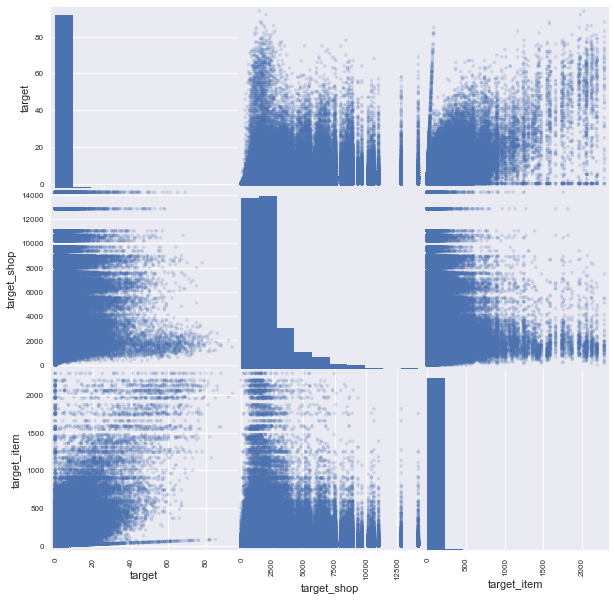

In [7]:
%pylab inline
pd.plotting.scatter_matrix(all_data[['target', 'target_shop', 'target_item']], alpha = 0.2, \
                                 figsize=(10,10), diagonal = 'hist')
pylab.show()

In [6]:
all_data[(all_data['item_id']==2574) & (all_data['shop_id']==28)].tail(13)

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,...,target_shop_lag_9,target_lag_10,target_item_lag_10,target_shop_lag_10,target_lag_11,target_item_lag_11,target_shop_lag_11,target_lag_12,target_item_lag_12,target_shop_lag_12
7838944,28,2574,22,2.0,5492.0,48.0,0.0,42.0,4695.0,8.0,...,5498.0,6.0,76.0,6949.0,9.0,121.0,8499.0,9.0,98.0,6454.0
8106029,28,2574,23,0.0,7439.0,63.0,2.0,48.0,5492.0,0.0,...,5901.0,6.0,61.0,5498.0,6.0,76.0,6949.0,9.0,121.0,8499.0
8551876,28,2574,24,3.0,6879.0,44.0,0.0,63.0,7439.0,2.0,...,4581.0,11.0,98.0,5901.0,6.0,61.0,5498.0,6.0,76.0,6949.0
8983583,28,2574,25,3.0,4234.0,26.0,3.0,44.0,6879.0,0.0,...,4902.0,4.0,65.0,4581.0,11.0,98.0,5901.0,6.0,61.0,5498.0
9269739,28,2574,26,1.0,4139.0,33.0,3.0,26.0,4234.0,3.0,...,5701.0,10.0,97.0,4902.0,4.0,65.0,4581.0,11.0,98.0,5901.0
9310454,28,2574,27,2.0,3686.0,35.0,1.0,33.0,4139.0,3.0,...,4536.0,6.0,89.0,5701.0,10.0,97.0,4902.0,4.0,65.0,4581.0
9658062,28,2574,28,2.0,3784.0,38.0,2.0,35.0,3686.0,1.0,...,5802.0,3.0,86.0,4536.0,6.0,89.0,5701.0,10.0,97.0,4902.0
9820720,28,2574,29,3.0,3921.0,24.0,2.0,38.0,3784.0,2.0,...,4403.0,10.0,94.0,5802.0,3.0,86.0,4536.0,6.0,89.0,5701.0
10237803,28,2574,30,0.0,3612.0,27.0,3.0,24.0,3921.0,2.0,...,4695.0,8.0,64.0,4403.0,10.0,94.0,5802.0,3.0,86.0,4536.0
10432126,28,2574,31,2.0,3749.0,30.0,0.0,27.0,3612.0,3.0,...,5492.0,0.0,42.0,4695.0,8.0,64.0,4403.0,10.0,94.0,5802.0


In [22]:
# c 12 периода берем недели, тк 12 заложили в shift !! 
all_data = all_data[all_data['date_block_num'] >= 12] 

shift_range = [1, 2, 3,4, 5,6, 12]
index_cols = ['shop_id', 'item_id', 'date_block_num']

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

In [23]:
all_data[(all_data['item_id']==2574) & (all_data['shop_id']==28)].tail(13).T

,3348171,3615165,4060541,4491773,4777653,4818330,5154813,5317448,5734173,5928379,6147107,6377879,6445792
shop_id,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0,28.0
item_id,2574.0,2574.0,2574.0,2574.0,2574.0,2574.0,2574.0,2574.0,2574.0,2574.0,2574.0,2574.0,2574.0
date_block_num,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0
target,2.0,0.0,3.0,3.0,1.0,2.0,2.0,3.0,0.0,2.0,1.0,1.0,0.0
target_shop,4715.0,6520.0,6077.0,4048.0,4002.0,3147.0,3379.0,3578.0,3323.0,3446.0,2575.0,2778.0,0.0
target_item,48.0,63.0,44.0,26.0,33.0,35.0,38.0,25.0,28.0,30.0,29.0,27.0,0.0
target_lag_1,0.0,2.0,0.0,3.0,3.0,1.0,2.0,2.0,3.0,0.0,2.0,1.0,1.0
target_item_lag_1,42.0,48.0,63.0,44.0,26.0,33.0,35.0,38.0,25.0,28.0,30.0,29.0,27.0
target_shop_lag_1,4173.0,4715.0,6520.0,6077.0,4048.0,4002.0,3147.0,3379.0,3578.0,3323.0,3446.0,2575.0,2778.0
target_lag_2,8.0,0.0,2.0,0.0,3.0,3.0,1.0,2.0,2.0,3.0,0.0,2.0,1.0


In [24]:
# добавим категориальный месяц
all_data['month'] = (all_data['date_block_num'] % 12+1)

# добавляем категориальный групп таргета
all_data['target_item_group'] = all_data['target_item'].apply(lambda x: 0 if x==0. else 1 if x<1000. \
                                                              else 3 if x>1900. else 2)
all_data = downcast_dtypes(all_data)

In [25]:
all_data['target_item_group'].value_counts()

1    6402838
0     214200
2       1240
3        494
Name: target_item_group, dtype: int64

In [26]:
all_data.tail(15).T

,6618757,6618758,6618759,6618760,6618761,6618762,6618763,6618764,6618765,6618766,6618767,6618768,6618769,6618770,6618771
shop_id,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0
item_id,14443.0,14341.0,5401.0,9500.0,16007.0,3280.0,4393.0,4352.0,18049.0,18027.0,18454.0,16188.0,15757.0,19648.0,969.0
date_block_num,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0
target,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
target_shop,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
target_item,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
target_lag_1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
target_item_lag_1,0.0,6.0,1.0,3.0,1.0,1.0,1.0,2.0,4.0,3.0,2.0,1.0,5.0,2.0,3.0
target_shop_lag_1,0.0,670.0,670.0,670.0,670.0,670.0,670.0,670.0,670.0,670.0,670.0,670.0,670.0,670.0,670.0
target_lag_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
all_data["date_block_num"].unique()

array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 32, 33, 34], dtype=int64)

In [27]:
# now separate train and test
test = pd.merge(test, all_data[all_data["date_block_num"] == 34], on=["shop_id", "item_id", "date_block_num"])
train = all_data[all_data["date_block_num"] < 34]

In [28]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = train['date_block_num']

last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 33


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,min_periods=2,center=False).mean()
  


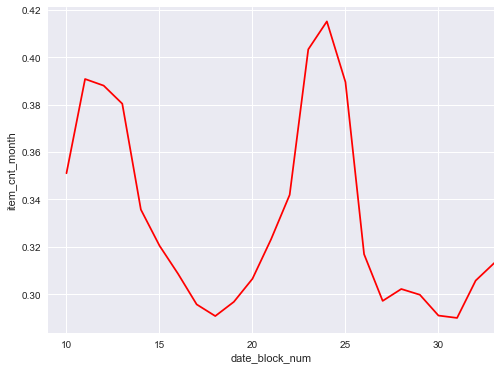

In [19]:
ax = pd.rolling_mean(train.groupby("date_block_num").target.mean(), 
                window=3, min_periods=2).plot(figsize=(8,6), c="r")

ax.set_ylabel("item_cnt_month")

# Maybe it worths to check previous months 

In [29]:
# validate our model on last month of train (October, 2015)

dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train = train.loc[dates <  last_block].drop(to_drop_cols, axis=1)
X_test =  train.loc[dates == last_block].drop(to_drop_cols, axis=1)

y_train = train.loc[dates <  last_block, 'target'].values
y_test =  train.loc[dates == last_block, 'target'].values

In [30]:
X_train.shape

(6166664, 26)

In [31]:
X_test.shape

(237908, 26)

In [ ]:
%%time
cat_features = [23,24,25] #[35,36,37]
boost = catboost.CatBoostRegressor(iterations=100)
boost.fit(X_train.values, y_train, cat_features)
preds = boost.predict(X_test)
print("catboost score = {}".format(mean_squared_error(y_test, preds)))

In [29]:
# 2 submition catboost score = 21.37743372459365 - [1, 2, 3, 9, 10, 11, 12]

In [23]:
# 4 submition catboost score = 21.90549276217584 - [1, 2, 3, 5, 7, 9, 11, 12] c 09 периода и 50 иттераций

In [29]:
# 5 submition пока лучший catboost score = 20.3901489860215 - [1, 2, 3, 5, 7, 9, 11, 12] c 09 периода и 100 иттераций

In [28]:
# 6 submition catboost score = 20.26857938813011 - [1, 2, 3, 5, 7, 9, 11, 12] c 09 периода и 150 иттераций 30 минут

In [14]:
%%time
test = test[X_train.columns]
preds = boost.predict(test)
ss = pd.read_csv("data/sample_submission.csv")
ss.item_cnt_month = preds
ss.to_csv("catboost_12_submit.csv", index=False)

Wall time: 2.4 s


In [4]:
ss = pd.read_csv("data/sample_submission.csv")
ss.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [7]:
ss.item_cnt_month.value_counts()

0.5    214200
Name: item_cnt_month, dtype: int64

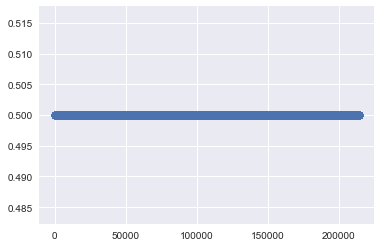

In [11]:
plt.scatter(ss.ID, ss.item_cnt_month)
plt.show()

In [20]:
all_data.tail().T

,6291943,6291944,6291945,6291946,6291947
shop_id,45.0,45.0,45.0,45.0,45.0
item_id,18454.0,16188.0,15757.0,19648.0,969.0
date_block_num,34.0,34.0,34.0,34.0,34.0
target,0.0,0.0,0.0,0.0,0.0
target_shop,0.0,0.0,0.0,0.0,0.0
target_item,0.0,0.0,0.0,0.0,0.0
target_lag_1,1.0,0.0,0.0,0.0,0.0
target_item_lag_1,2.0,1.0,5.0,2.0,3.0
target_shop_lag_1,702.0,702.0,702.0,702.0,702.0
target_lag_2,0.0,0.0,0.0,0.0,0.0


In [9]:
feats = ['month', 'item_category_id', 'target_item_group']
all_data[feats].head()

,month,item_category_id,target_item_group
0,9,55,1
1,9,55,1
2,9,23,1
3,9,19,1
4,9,55,1


In [10]:
%%time
from sklearn.feature_extraction import DictVectorizer as DV

feats = ['month', 'item_category_id', 'target_item_group']
#dict_vect = DV(sparse=False)
#dict_vect_matrix = dict_vect.fit_transform(all_data[feats].T.to_dict().values())
#print (dict_vect_matrix[:2])

Wall time: 11 ms


In [9]:
temp1 = pd.get_dummies(all_data['month'], prefix='month')
temp2 = pd.get_dummies(all_data['item_category_id'], prefix='item_category_id')
temp3 = pd.get_dummies(all_data['target_item_group'], prefix='target_item_group')
print (temp1.shape, temp2.shape, temp3.shape)

(7762897, 12) (7762897, 81) (7762897, 3)


In [10]:
X1 = pd.concat([all_data, temp1, temp2, temp3], axis=1)
#X1.drop(feats, axis=1, inplace=True)
X1.shape

(7762897, 138)

In [11]:
feats = ['month', 'item_category_id', 'target_item_group']
X1.drop(feats, axis=1, inplace=True)

In [12]:
X1 = downcast_dtypes(X1)
X1.shape

(7762897, 135)

In [33]:
X1.head(2)

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,...,item_category_id_77,item_category_id_78,item_category_id_79,item_category_id_80,item_category_id_81,item_category_id_82,item_category_id_83,target_item_group_1,target_item_group_2,target_item_group_3
0,44,3624,9,1.0,1678.0,22.0,0.0,18.0,1849.0,2.0,...,0,0,0,0,0,0,0,1,0,0
1,44,3620,9,1.0,1678.0,20.0,0.0,15.0,1849.0,1.0,...,0,0,0,0,0,0,0,1,0,0
2,44,3734,9,12.0,1678.0,2558.0,34.0,3223.0,1849.0,0.0,...,0,0,0,0,0,0,0,1,0,0
3,44,3732,9,30.0,1678.0,2753.0,73.0,6972.0,1849.0,0.0,...,0,0,0,0,0,0,0,1,0,0
4,44,3626,9,2.0,1678.0,18.0,2.0,14.0,1849.0,1.0,...,0,0,0,0,0,0,0,1,0,0


In [13]:
# now separate train and test
test = pd.merge(test, X1[X1["date_block_num"] == 34], on=["shop_id", "item_id", "date_block_num"])
train = X1[X1["date_block_num"] < 34]

In [14]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = train['date_block_num']

last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 33


In [15]:
# validate our model on last month of train (October, 2015)

dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train = train.loc[dates <  last_block].drop(['target', 'date_block_num'], axis=1)
X_test =  train.loc[dates == last_block].drop(['target', 'date_block_num'], axis=1)

y_train = train.loc[dates <  last_block, 'target'].values
y_test =  train.loc[dates == last_block, 'target'].values

In [17]:
X_train.head()

,shop_id,item_id,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,...,item_category_id_77,item_category_id_78,item_category_id_79,item_category_id_80,item_category_id_81,item_category_id_82,item_category_id_83,target_item_group_1,target_item_group_2,target_item_group_3
0,44,3624,1678.0,22.0,0.0,18.0,1849.0,2.0,45.0,1610.0,...,0,0,0,0,0,0,0,1,0,0
1,44,3620,1678.0,20.0,0.0,15.0,1849.0,1.0,26.0,1610.0,...,0,0,0,0,0,0,0,1,0,0
2,44,3734,1678.0,2558.0,34.0,3223.0,1849.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
3,44,3732,1678.0,2753.0,73.0,6972.0,1849.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
4,44,3626,1678.0,18.0,2.0,14.0,1849.0,1.0,16.0,1610.0,...,0,0,0,0,0,0,0,1,0,0


In [16]:
%%time
boost = catboost.CatBoostRegressor(iterations=100)
boost.fit(X_train.values, y_train)
preds = boost.predict(X_test)
print("catboost score = {}".format(mean_squared_error(y_test, preds)))

MemoryError: 

In [17]:
%%time
#linear_reg

regressor = LinearRegression(n_jobs=-1)
regressor.fit(X_train, y_train)
preds = regressor.predict(X_test)
print("regressor score = {}".format(mean_squared_error(y_test, preds)))

MemoryError: 

In [17]:
resids = y_test - preds
resids[0:20]

array([ 0.87759796,  0.04996003,  1.13516374,  0.81209349,  0.73963571,
        2.76876464,  0.82982276,  1.78932748,  0.7086489 ,  0.72629655,
        0.77080217,  0.96980633,  0.3835387 ,  0.83028258,  0.86770194,
        0.79360777,  0.35176268,  0.92846114,  0.35399381,  0.8525124 ])

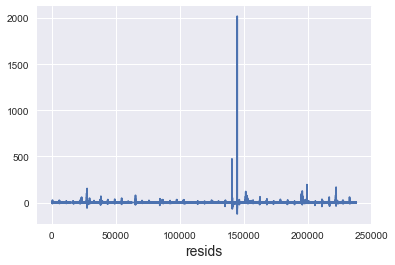

In [22]:
plt.plot(resids)
plt.xlabel('resids', fontsize=14)

In [25]:
resids.sort()

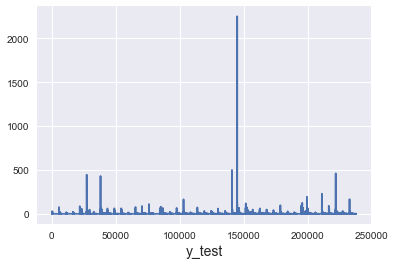

In [27]:
plt.plot(y_test)
plt.xlabel('y_test', fontsize=14)

In [29]:
np.quantile(train['target'], 0.75)

AttributeError: module 'numpy' has no attribute 'quantile'

### Посмотрим на данные в датасете

In [20]:
import statsmodels
import scipy as sc
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
%pylab inline

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test', 'product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """Entry point for launching an IPython kernel.


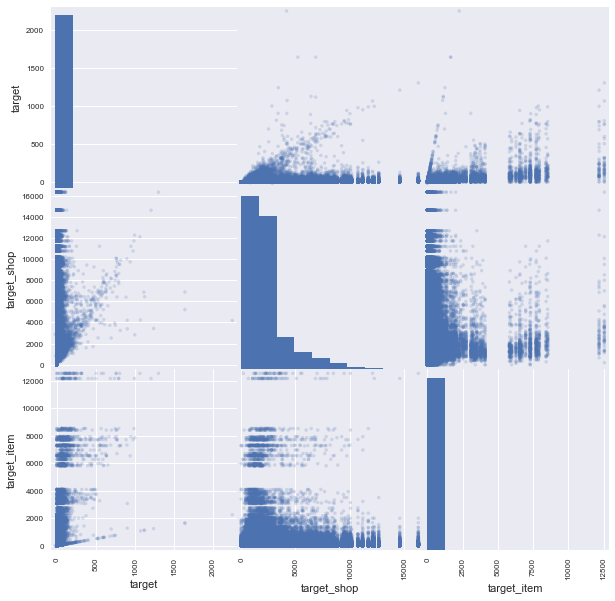

In [21]:
pd.plotting.scatter_matrix(all_data[['target', 'target_shop', 'target_item']], alpha = 0.2, \
                                 figsize=(10,10), diagonal = 'hist')
pylab.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


ValueError: range parameter must be finite.

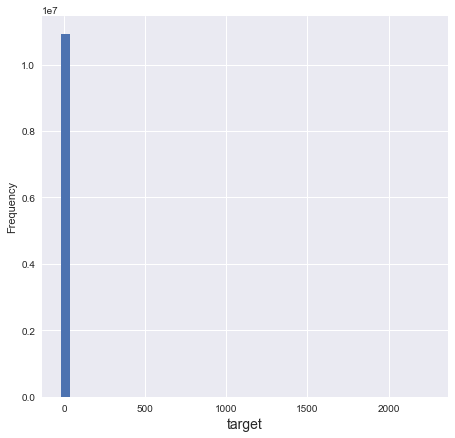

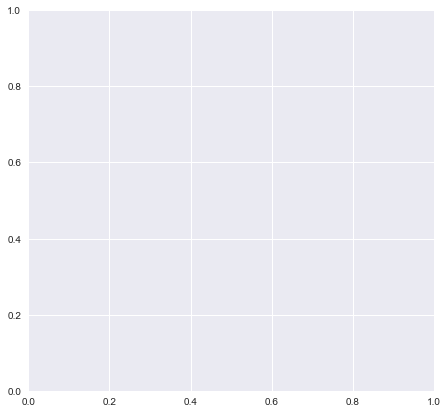

In [28]:
plt.figure(figsize(16,7))
plt.subplot(121)
train['target'].plot.hist(bins = 40)
plt.xlabel('target', fontsize=14)

bins2 = np.asarray([0,4,8,10, 15, 20])
plt.figure(figsize(16,7))
plt.subplot(122)
np.log(train['target']).plot.hist()
plt.xlabel('target', fontsize=14)

In [31]:
#см какие товары есть в тесте, но нет в трейне
print ('сколько артикулов из теста нет в трейне ' , (set(test['item_id']).difference(set(train['item_id']))))
print ('кол-во артикулов в тесте ', len(test['item_id'].unique()))
print ('кол-во артикулов в трейне ', len(train['item_id'].unique()))       

TypeError: 'method' object is not subscriptable

In [ ]:
train['target'].describe()

In [44]:
len(train['target_item'].value_counts())

841

In [36]:
test.head()

AttributeError: 'function' object has no attribute 'head'